In [1]:
import functools
import multiprocessing
from pathlib import Path
from copy import deepcopy

import numpy as np

from astropy import units as u
from astropy.io import fits
from astropy.modeling import models

from astroquery.svo_fps import SvoFps


from specutils import Spectrum1D, manipulation

from astropy.visualization import quantity_support
quantity_support()

from matplotlib import pyplot as plt

from tqdm.auto import tqdm

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
tensor_dtype = torch.float32
if device == 'cpu':
    tensor_dtype = torch.float64
print(f"Using {device} device with dtype {tensor_dtype}")

Using cuda device with dtype torch.float32


In [3]:
datapath = Path('../fullgrid/')

# Load Data

Mostly taken from [resampling_tensors.ipynb](resampling_tensors.ipynb)

In [4]:
wlspath = datapath / 'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'

wlsraw = fits.getdata(wlspath)
model_wls = wlsraw << u.Unit(fits.getheader(wlspath)['UNIT'])

model_wls, len(model_wls)

(<Quantity [  500.  ,   500.1 ,   500.2 , ..., 54999.25, 54999.5 , 54999.75] Angstrom>,
 1569128)

In [5]:
allspecpaths = list(datapath.glob('lte*HiRes.fits'))
len(allspecpaths)

7559

In [6]:
specunit = u.Unit(fits.getval(allspecpaths[0], 'BUNIT'))

# Pick bands and wavelength range

In [7]:
filters = ['HST/WFC3_UVIS1.F275W', 'HST/WFC3_UVIS1.F336W', 
           'HST/ACS_WFC.F475W', 'HST/ACS_WFC.F814W', 
           'HST/WFC3_IR.F110W', 'HST/WFC3_IR.F160W']

transmission = {filtname.split('.')[-1]:SvoFps.get_transmission_data(filtname) for filtname in filters}

In [8]:
wls = [u.Quantity(ttab['Wavelength'], u.angstrom) for ttab in transmission.values()]

dwls = []
for wl in wls:
    dwls.append(np.diff(wl))
dwls = np.concatenate(dwls)

qs = np.quantile(dwls, [.01, .05, .1, .5, .9])
qs

<Quantity [4.880000e-04, 4.995120e-01, 5.000000e-01, 5.000000e-01,
           3.592285e+00] Angstrom>

In [9]:
dwl = qs[2]
dwl

<Quantity 0.5 Angstrom>

In [10]:
minwl = np.concatenate(wls).min()
maxwl = np.concatenate(wls).max()
minwl, maxwl

(<Quantity 2161. Angstrom>, <Quantity 17204.697266 Angstrom>)

In [11]:
minwl

<Quantity 2161. Angstrom>

In [12]:
(minwl.to(u.angstrom), maxwl.to(u.angstrom), dwl.to(u.angstrom))

(<Quantity 2161. Angstrom>,
 <Quantity 17204.697266 Angstrom>,
 <Quantity 0.5 Angstrom>)

In [13]:
(maxwl-minwl)//dwl  + 1

<Quantity 30088.>

In [14]:
fine_wl = np.linspace(minwl.to(u.angstrom)*.99, maxwl.to(u.angstrom)*1.01, int((maxwl*1.01-minwl*.99)//dwl  + 1))
len(fine_wl)

30475

that's way too fine to realistically train.  Lets try shrinking it down:

In [15]:
data_wls = fine_wl[::10]
len(data_wls)

3048

# Do the interpolation and data prep

In [16]:
resampler = manipulation.FluxConservingResampler()

def interpolate_and_return_flux(specpath, data_wls=data_wls, resampler=resampler):
    header = dict(fits.getheader(specpath, ext=0))
    spec = Spectrum1D(spectral_axis=model_wls, flux=fits.getdata(specpath, ext=0) << u.Unit(header['BUNIT']))
    newspec = resampler(spec, data_wls)

    return newspec.flux.value

In [17]:
tointerpolate = [p for p in allspecpaths if 'BUNIT' in fits.getheader(p)]
len(tointerpolate), len(allspecpaths)

with multiprocessing.Pool(16) as pool:
      results = list(tqdm(pool.imap(interpolate_and_return_flux, tointerpolate), total=len(tointerpolate)))
len(results)

  0%|          | 0/7508 [00:00<?, ?it/s]

7508

In [18]:
fluxes = torch.from_numpy(np.array(results))
fluxes.shape

torch.Size([7508, 3048])

In [19]:
bbfluxes = []
for p in tqdm(tointerpolate):
    hdr = fits.getheader(p, 0)
    bb = models.BlackBody(temperature=hdr['PHXTEFF']*u.K, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
    flux = bb(wl << u.angstrom)*(np.pi*u.sr)
    bbfluxes.append(flux.to(u.erg/u.s * u.cm**-3).value)
bbfluxes = torch.from_numpy(np.array(bbfluxes))

bbmean = bbfluxes.mean(axis=-1)

bbsimplescale = fluxes/bbmean[...,None] - 1

  0%|          | 0/7508 [00:00<?, ?it/s]

In [20]:
teff = torch.tensor([fits.getval(p, 'PHXTEFF') for p in tointerpolate])
logg = torch.tensor([fits.getval(p, 'PHXLOGG') for p in tointerpolate])
feh = torch.tensor([fits.getval(p, 'PHXM_H') for p in tointerpolate])

infeatures = torch.stack([teff,logg,feh], dim=1)
infeature_names = 'Teff,logg,FeH'.split(',')

# train emulator

## Autoencoder

In [21]:
class Encoder(nn.Module):
    def __init__(self, npix, nneurons, activation_cls):
        super().__init__()

        prev_layern = npix
        stack = []
        for nneur in nneurons:
            stack.append(nn.Linear(prev_layern, nneur))
            stack.append(activation_cls())
            prev_layern = nneur
            
        self.stack = nn.Sequential(*stack)

    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype
        
    @property
    def npix(self):
        return self.stack[0].num_features
        
    @property
    def latent_size(self):
        return self.stack[-1].num_features
        
    def forward(self, x):
        return self.stack(x)

class Decoder(nn.Module):
    def __init__(self, npix, nneurons, activation_cls):
        super().__init__()

        prev_layern = nneurons[0]
        stack = []
        for nneur in nneurons[1:]:
            stack.append(nn.Linear(prev_layern, nneur))
            stack.append(activation_cls())
            prev_layern = nneur
        stack.append(nn.Linear(prev_layern, npix))
            
        self.stack = nn.Sequential(*stack)

    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype
        
    @property
    def npix(self):
        return self.stack[-1].num_features
        
    @property
    def latent_size(self):
        return self.stack[0].num_features
        
    def forward(self, x):
        return self.stack(x)
        
class Autoencoder(nn.Module):
    def __init__(self, npix, nneurons, activation_cls=nn.GELU):
        super().__init__()

        self.encoder = Encoder(npix, nneurons, activation_cls)
        self.decoder = Decoder(npix, nneurons[::-1], activation_cls)

    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype
        
    @property
    def npix(self):
        return self.encoder.stack[0].num_features
        
    @property
    def latent_size(self):
        return self.encoder.stack[-1].num_features
        
    def forward(self, x):
        x = torch.atleast_2d(x)
        latent = self.encoder(x)
        return self.decoder(latent)


In [22]:
def train_validation(model, dataset, nepochs, batch_size, lr, ttsplit=[.3, .7], inner_validation=False, weight_decay=0, eps=1e-8, loss_fcn=nn.MSELoss(), scheduler_fcn=None):
    split_data = random_split(dataset, ttsplit, torch.Generator().manual_seed(42))
    valid_data, train_data = split_data
    valid_X, valid_Y = valid_data.dataset.tensors[:2]
    
    valid_losses = []
    valid_niters = []

    train_losses = []
    train_niters = []

    lrs = []
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, eps=eps)
    if scheduler_fcn is not None:
        scheduler = scheduler_fcn(optimizer)
    
    niters = 0

    def validation_fcn():
        model.eval()
        with torch.no_grad():
            pred = model(valid_X)
            valid_loss = loss_fcn(pred,valid_Y).item()
            valid_losses.append(valid_loss)
            valid_niters.append(niters)
        return valid_loss
    
    for _ in (pbar := tqdm(range(nepochs))):
        model.train()
    
        for data in DataLoader(train_data, batch_size=batch_size, shuffle=True):
            X, Y = data[:2]
            optimizer.zero_grad()
            
            pred = model(X)
            loss = loss_fcn(pred, Y)
            
            loss.backward()
            optimizer.step()
    
            niters += X.shape[0]
            
            train_losses.append(loss.item())
            train_niters.append(niters)

            if inner_validation:
                valid_loss = validation_fcn()
                
                if scheduler_fcn is not None:
                    scheduler.step()
                    lrs.append(scheduler.get_last_lr())
            
        if not inner_validation:
            if scheduler_fcn is not None:
                scheduler.step()
                lrs.append(scheduler.get_last_lr())
                
            valid_loss = validation_fcn()
                
        if scheduler_fcn is None:
            pbar.set_description(f'valid loss={valid_loss:.3e}')
        else:
            pbar.set_description(f'valid loss={valid_loss:.3e}, lr={lrs[-1][0]:.3e}')
            
    if scheduler_fcn is None:
        return (valid_niters, valid_losses), (train_niters, train_losses), split_data
    else:
        return (valid_niters, valid_losses), (train_niters, train_losses), lrs, split_data

In [23]:
def plot_sample_specs2(model, data_split, descaler=None, wl=data_wls.to(u.Angstrom).value, xisfeatures=False):
    valid_data, train_data = data_split
    valid_idxs = np.random.randint(len(valid_data), size=5)

    figs = []
    for valid_idx in valid_idxs:
        if xisfeatures:
            infeaturesi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
            Xi = infeaturesi
        else:
            Xi, Yi, infeaturesi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
        
        pred = model(Xi[None,...])[0].detach()

        if descaler is not None:
            pred = descaler(pred, infeaturesi)
            Yi = fluxes[np.array(valid_data.indices[valid_idx])]
            
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        figs.append(fig)
        ax1, ax2 = axs
        
        ax1.plot(wl, Yi.cpu(), lw=1, label='true')
        ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
        ax1.legend(loc=0)
        ax1.set_title(f'{valid_idx}')
        
        msk = (14000<wl)&(wl<15000)
        ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
        ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
        ax2.legend(loc=0)
        ax2.set_title(f'{valid_idx} - zoom')
        
    return valid_idxs, figs

def plot_sample_specs3(model, data_split, descaler=None, wl=data_wls.to(u.Angstrom).value):
    valid_data, train_data = data_split
    valid_idxs = np.random.randint(len(valid_data), size=5)

    figs = []
    for valid_idx in valid_idxs:
        Xi, Yi, infeaturesi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
        
        pred = model(Xi[None,...])[0].detach()

        if descaler is not None:
            pred = descaler(pred, infeaturesi)
            Yi = fluxes[np.array(valid_data.indices[valid_idx])]
            
        fig, axs = plt.subplots(1, 3, figsize=(12, 6))
        figs.append(fig)
        ax1, ax2, ax3 = axs
        
        ax1.plot(wl, Yi.cpu(), lw=1, label='true')
        ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
        ax1.legend(loc=0)
        ax1.set_title(f'{valid_idx}')
        
        msk = (14000<wl)&(wl<15000)
        ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
        ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
        ax2.legend(loc=0)
        ax2.set_title(f'{valid_idx} - zoom')
        
        ax3.plot(wl, (Yi.cpu()-pred.cpu())/Yi.cpu(), lw=1, label='true')
        ax3.set_title(f'{valid_idx} - frac residual')
        
    return valid_idxs, figs

  0%|          | 0/4000 [00:00<?, ?it/s]

(array([ 386,  173,  108, 1846,  724]),
 [<Figure size 1200x600 with 3 Axes>,
  <Figure size 1200x600 with 3 Axes>,
  <Figure size 1200x600 with 3 Axes>,
  <Figure size 1200x600 with 3 Axes>,
  <Figure size 1200x600 with 3 Axes>])

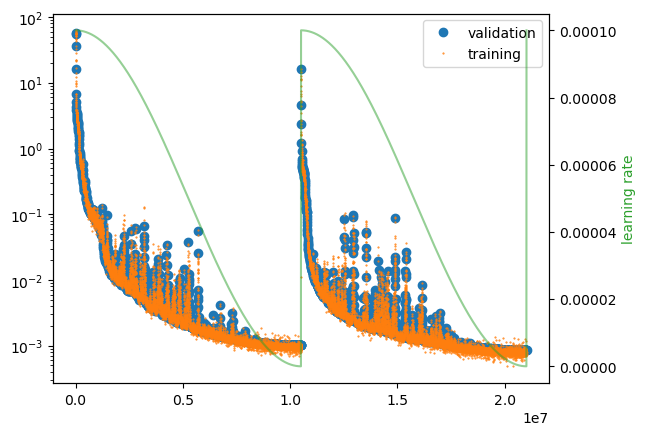

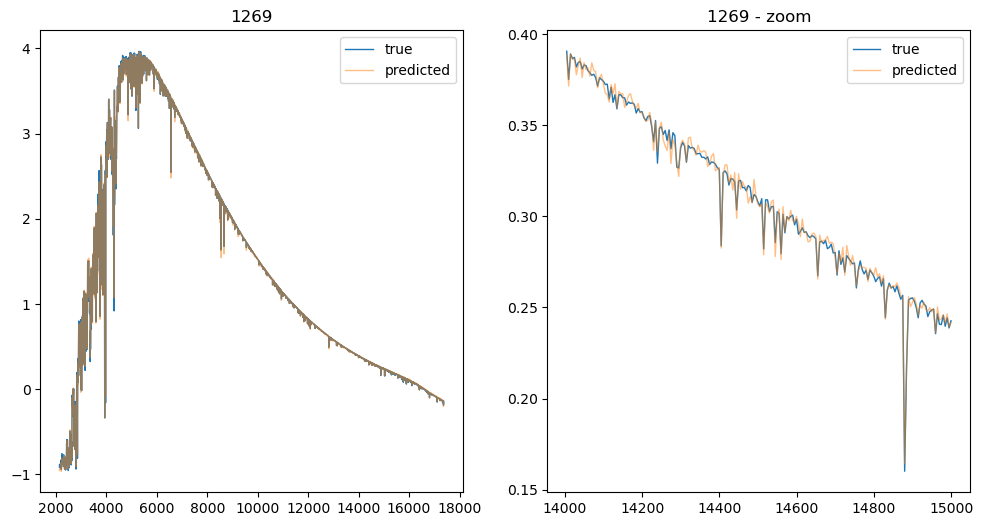

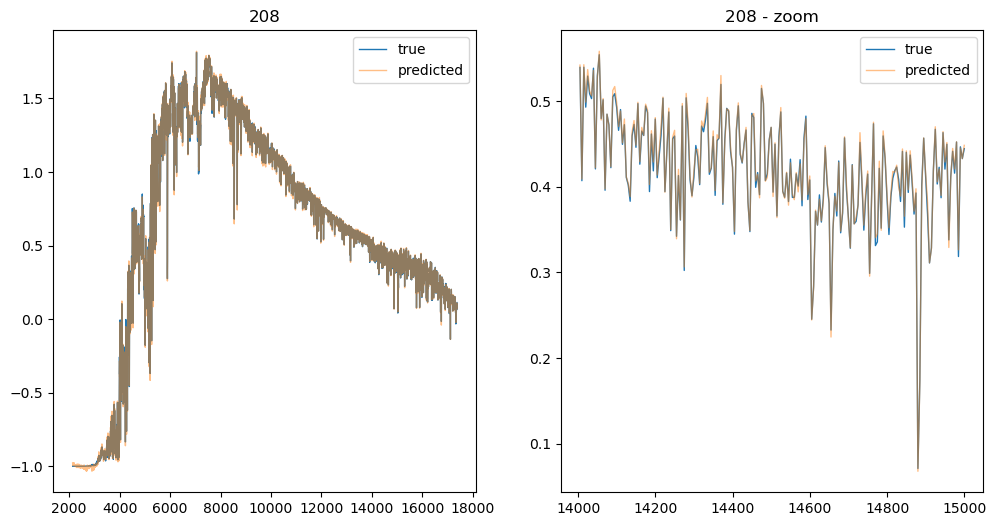

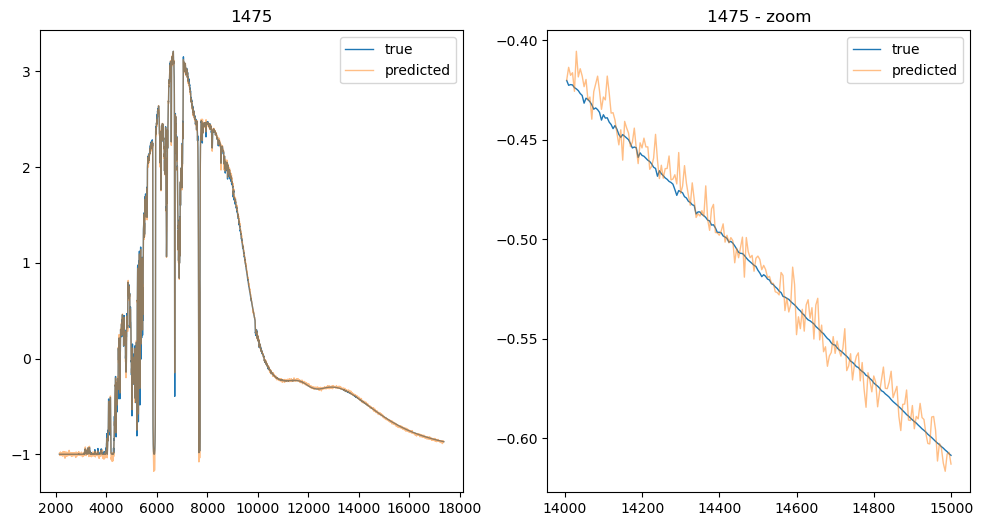

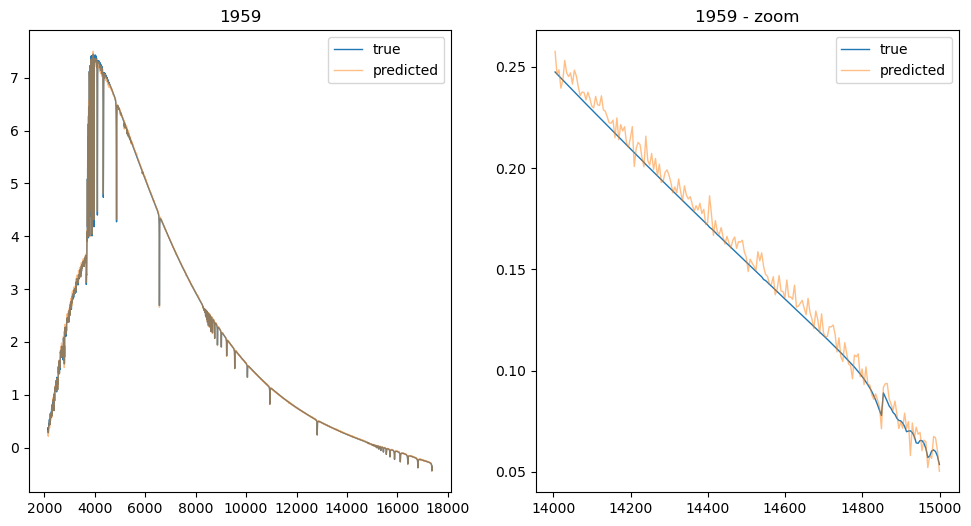

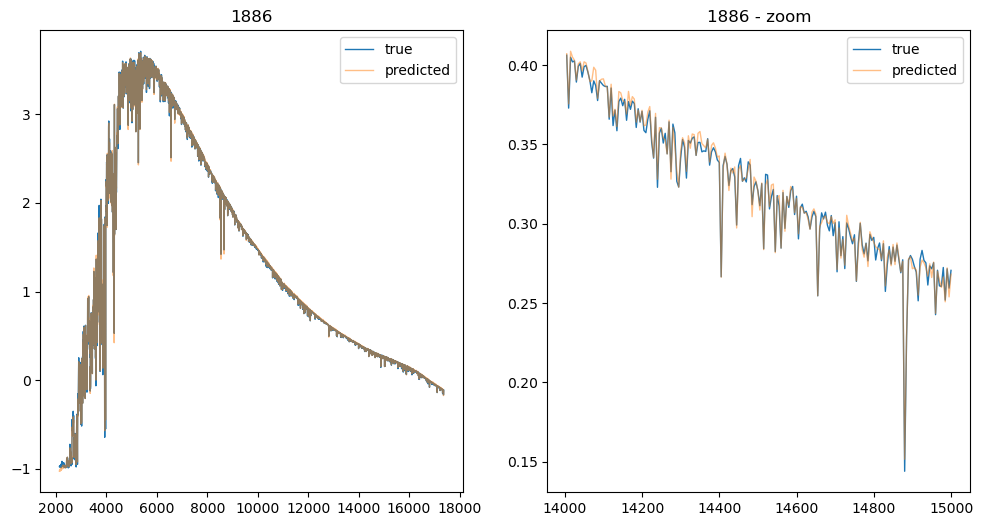

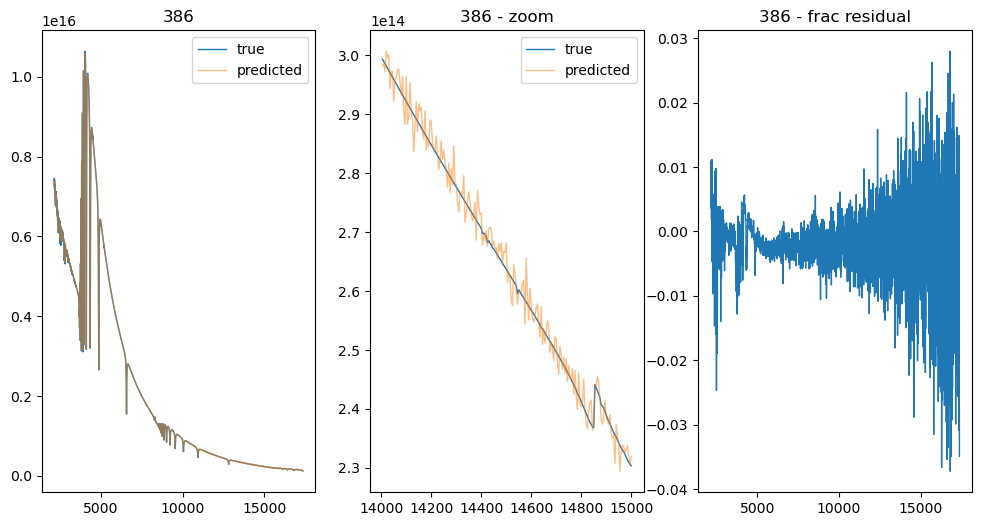

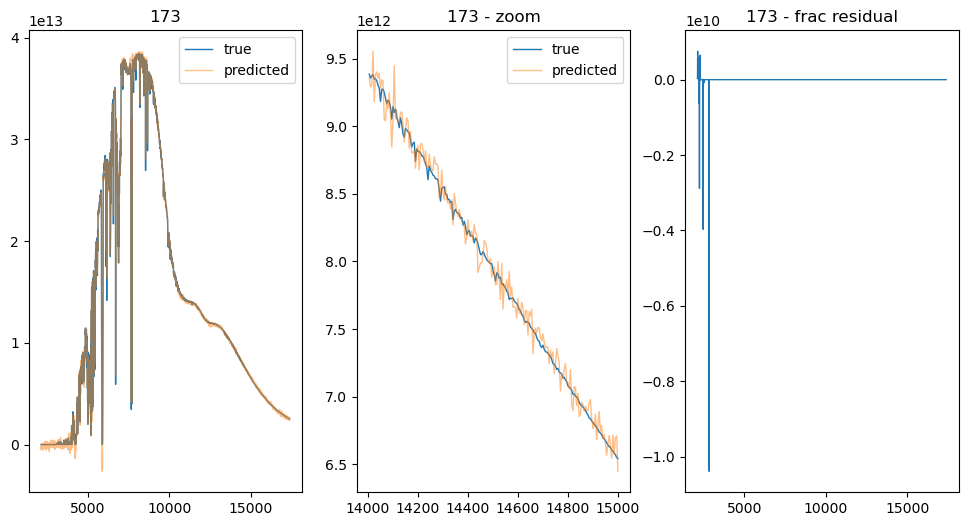

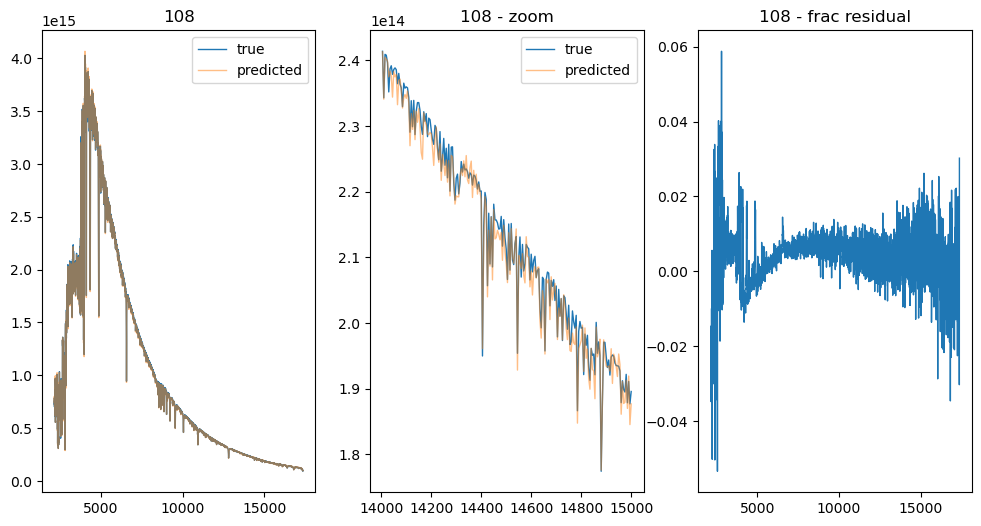

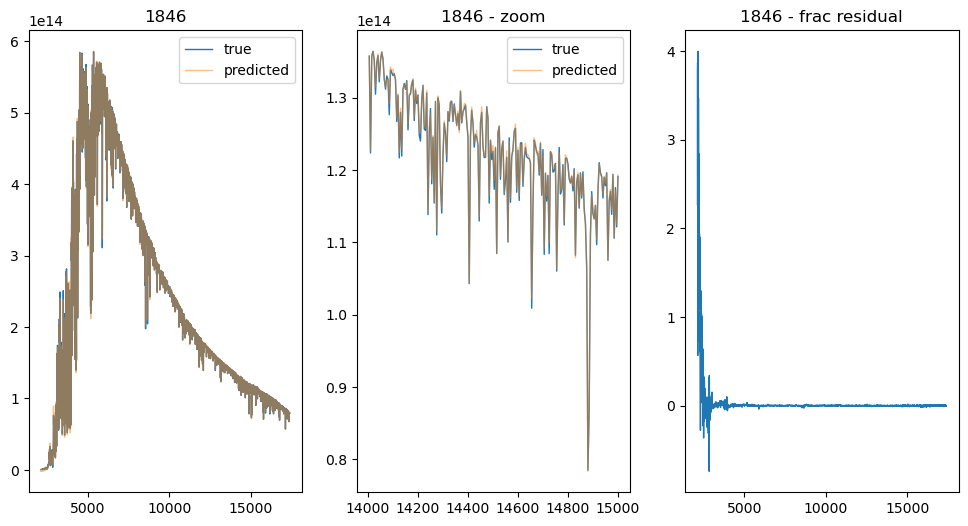

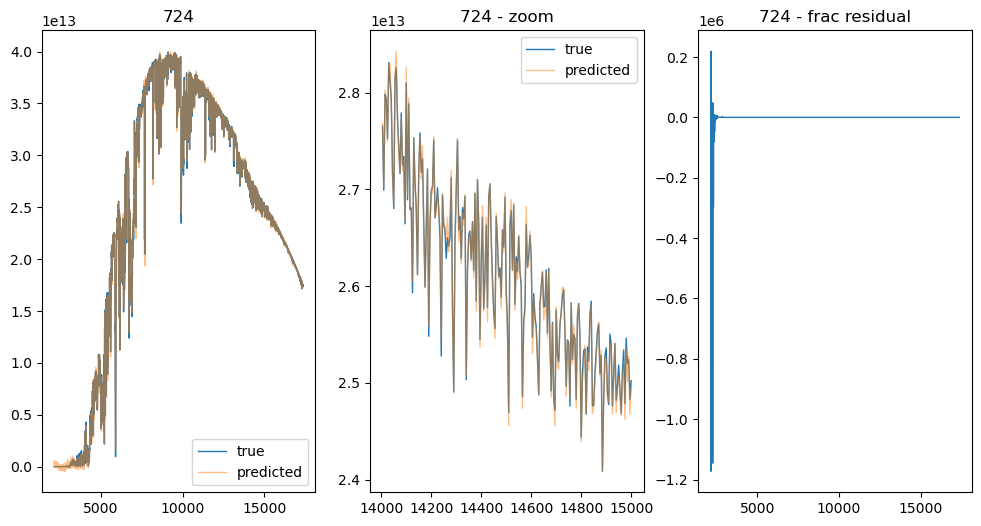

In [24]:
nneurons = 4096//(2**np.arange(6)[1:])

nperrestart = 2000
nrestarts = 2
lr = 1e-4
wd = 1e-5


model = aec = Autoencoder(fluxes.shape[-1], nneurons).to(device, tensor_dtype)

ds = TensorDataset(bbsimplescale.to(device, tensor_dtype), bbsimplescale.to(device, tensor_dtype), infeatures.to(device, tensor_dtype))

nepochs = nperrestart*nrestarts
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=ds, 
                                            nepochs=nepochs, 
                                            batch_size=1024, 
                                            lr=lr, 
                                            weight_decay=wd, 
                                            loss_fcn=nn.MSELoss(), 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')

plot_sample_specs2(model, data_split)

def descaler(y, infeatures):
    bb = models.BlackBody(temperature=infeatures[0].item()*u.K, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
    bbflux = (bb(wl << u.angstrom)*(np.pi*u.sr)).to(u.erg/u.s * u.cm**-3).value
    return (y + 1)*bbflux.mean() 
    
plot_sample_specs3(model, data_split, descaler)

In [25]:
latent_data = aec.encoder(ds.tensors[1]).detach()
in_to_latent_ds = TensorDataset(infeatures.to(device, tensor_dtype), latent_data)

class MLPSkip(nn.Module):
    def __init__(self, in_nfeatures, out_nfeatures, skip_layer_nneurons, 
                 inner_layers_nneurons, batchnorm='firstonly', activation_cls=nn.GELU):
        super().__init__()

        top_stack = []
        if batchnorm:
            top_stack.append(nn.BatchNorm1d(in_nfeatures))
        top_stack.append(nn.Linear(in_nfeatures, skip_layer_nneurons))
        top_stack.append(activation_cls())
        self.top_layers = nn.Sequential(*top_stack)
        

        prev_layern = skip_layer_nneurons
        inner_stack = []            
        for nneurons in inner_layers_nneurons + [skip_layer_nneurons]:
            if batchnorm and batchnorm != 'firstonly':
                inner_stack.append(nn.BatchNorm1d(nneurons))
            inner_stack.append(nn.Linear(prev_layern, nneurons))
            inner_stack.append(activation_cls())
            prev_layern = nneurons
        self.inner_layers = nn.Sequential(*inner_stack)

        self.bottom_layers = nn.Sequential(nn.Linear(skip_layer_nneurons, out_nfeatures),
                                          activation_cls())


    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype
        
    @property
    def in_nfeatures(self):
        return self.top_layers[0].num_features
        
    @property
    def out_nfeatures(self):
        return self.bottom_layers[0].out_features

    def forward(self, x):
        hidden1 = self.top_layers(x)
        hidden2 = self.inner_layers(hidden1)
        return self.bottom_layers(hidden2 + hidden1)
    

  0%|          | 0/3000 [00:00<?, ?it/s]

Text(0, 0.5, 'learning rate')

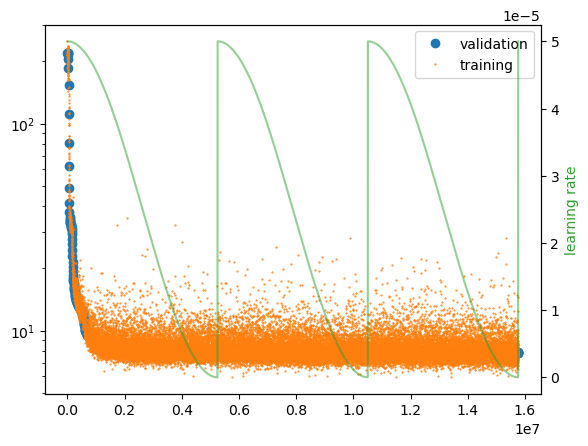

In [26]:
model = mlp = MLPSkip(infeatures.shape[-1], latent_data.shape[-1], 256, [512, 1024, 512]).to(device)

nperrestart = 1000
nrestarts = 3
nepochs = nperrestart*nrestarts
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=in_to_latent_ds, 
                                            nepochs=nepochs, 
                                            batch_size=512, 
                                            lr=5e-5, 
                                            weight_decay=1e-3*0, 
                                            loss_fcn=nn.MSELoss(), 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')


# valid_data, train_data = data_split

# vin, vlatent = [t[valid_data.indices] for t in valid_data.dataset.tensors]
# pred_latent = model(vin).detach()

# fig, axs = plt.subplots(latent_data.shape[-1], 3, figsize=(12, 20))
# for i, axrow in enumerate(axs):
#     for j, (inf, ax) in enumerate(zip(vin.T, axrow)):
#         ax.scatter(vlatent[:, i].cpu(), pred_latent[:, i].cpu(), s=1, alpha=.5, c=inf.cpu())
#         mx = max(vlatent[:, i].max(), pred_latent[:, i].max()).item()
#         mi = max(vlatent[:, i].min(), pred_latent[:, i].min()).item()
#         ax.plot([mi, mx], [mi, mx], c='k', ls=':')
#         if i == 0:
#             if j == 0:
#                 ax.set_title('c = Teff')
#             elif j == 1:
#                 ax.set_title('c = logg')
#             elif j == 2:
#                 ax.set_title('c = [Fe/H]')
#         ax.set_xticks([])
#         ax.set_yticks([])
# fig.tight_layout()

In [27]:
class CombinedModel(nn.Module):
    def __init__(self, aec, mlp):
        super().__init__()

        self.decoder = deepcopy(aec.decoder)
        self.mlp = deepcopy(mlp)

    def forward(self, x):
        latent = self.mlp(x)
        return self.decoder(latent)

    def forward_descale(self, x):
        y = self.forward(x)
        teff = x[:,:1].cpu().numpy()*u.K
        return self.descale(y, teff)

    def descale(self, y, teff):
        bb = models.BlackBody(temperature=teff, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
        bbflux = (bb(wl << u.angstrom)*(np.pi*u.sr)).to(u.erg/u.s * u.cm**-3).value
        return (y + 1)*bbflux.mean() 
        

  0%|          | 0/2000 [00:00<?, ?it/s]

(array([ 658, 1446, 1650, 2219, 1717]),
 [<Figure size 1200x600 with 2 Axes>,
  <Figure size 1200x600 with 2 Axes>,
  <Figure size 1200x600 with 2 Axes>,
  <Figure size 1200x600 with 2 Axes>,
  <Figure size 1200x600 with 2 Axes>])

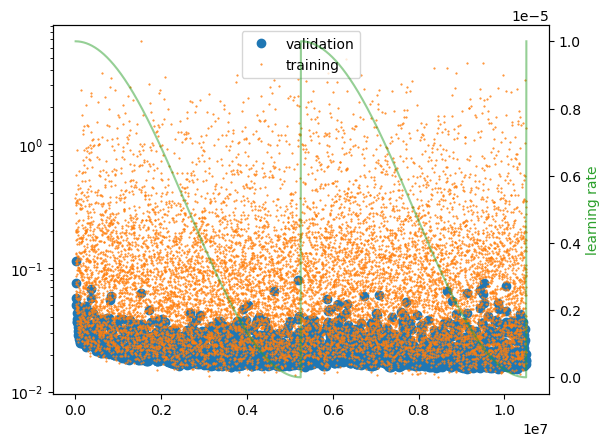

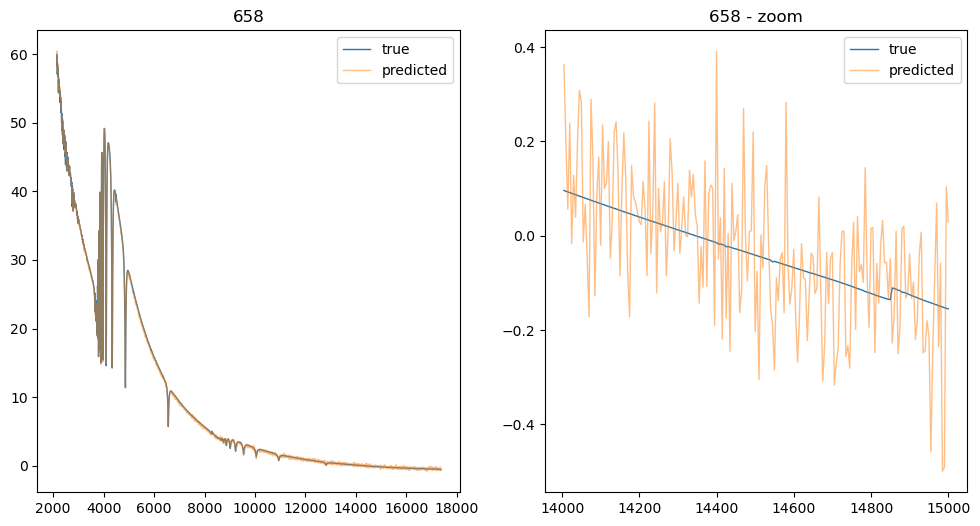

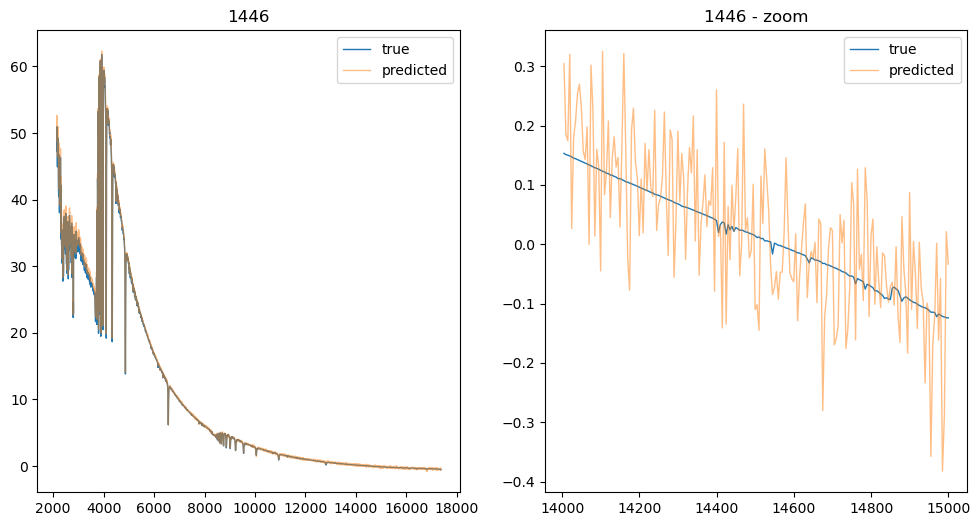

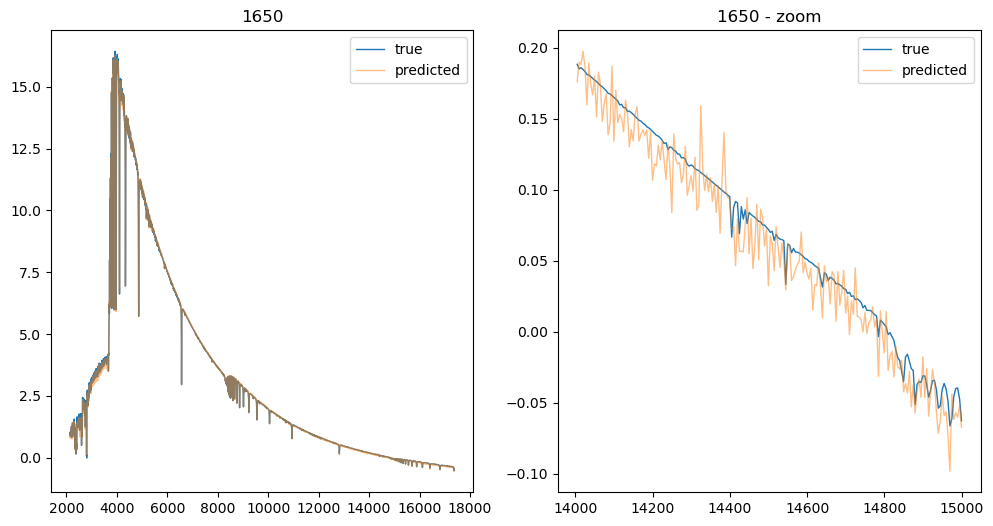

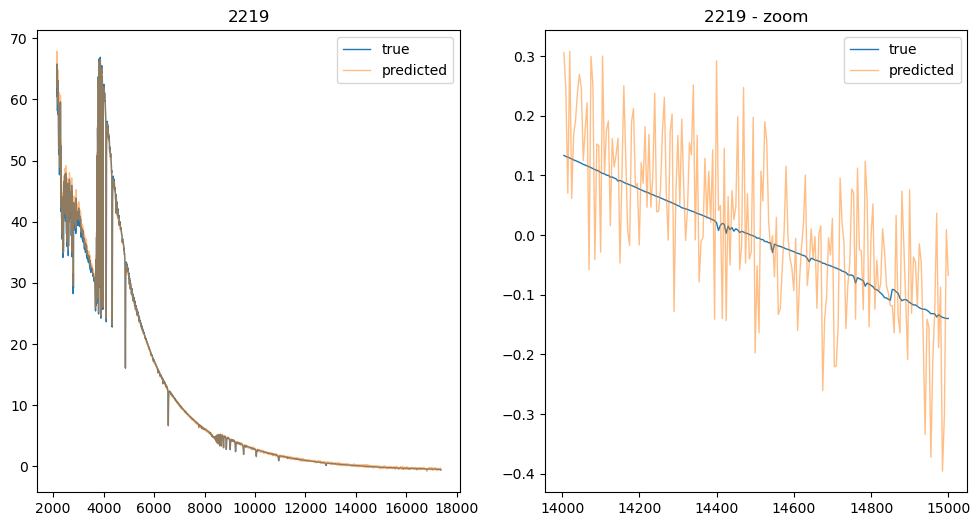

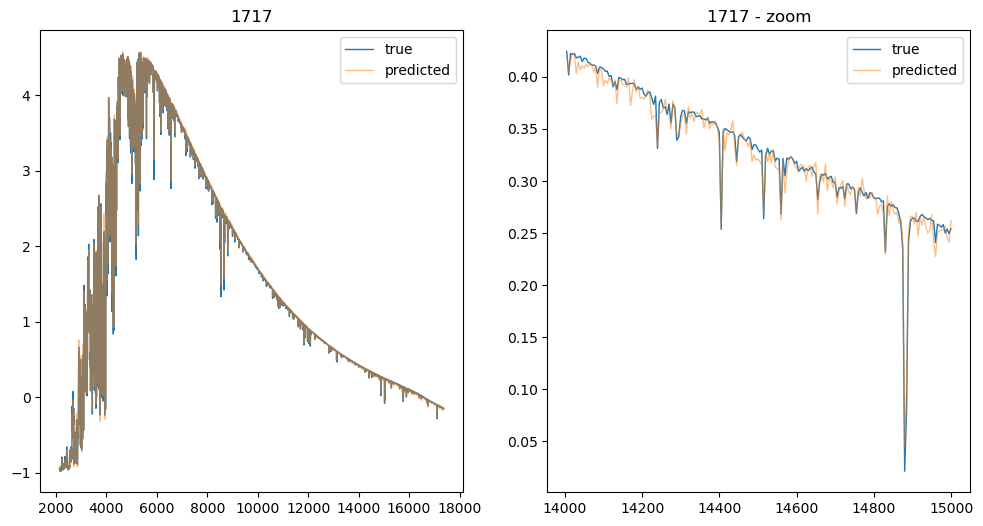

In [28]:
combined = CombinedModel(aec, mlp)

nperrestart = 1000
nrestarts = 2
lr = 1e-5
wd = 1e-5

# don't re-train the decoder model at all
for param in combined.decoder.parameters():
    param.requires_grad = False
for param in combined.mlp.parameters():
    param.requires_grad = True

ds = TensorDataset(infeatures.to(device, tensor_dtype), bbsimplescale.to(device, tensor_dtype))

nepochs = nperrestart*nrestarts
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
valid, train, lrs, data_split = train_validation(combined, 
                                            dataset=ds, 
                                            nepochs=nepochs, 
                                            batch_size=1024, 
                                            lr=lr, 
                                            weight_decay=wd, 
                                            loss_fcn=nn.MSELoss(), 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')

plot_sample_specs2(combined, data_split, xisfeatures=True)

[0.5836799740791321,
 0.44438400864601135,
 0.4205760061740875,
 0.4591360092163086,
 0.546720027923584,
 0.38630399107933044]

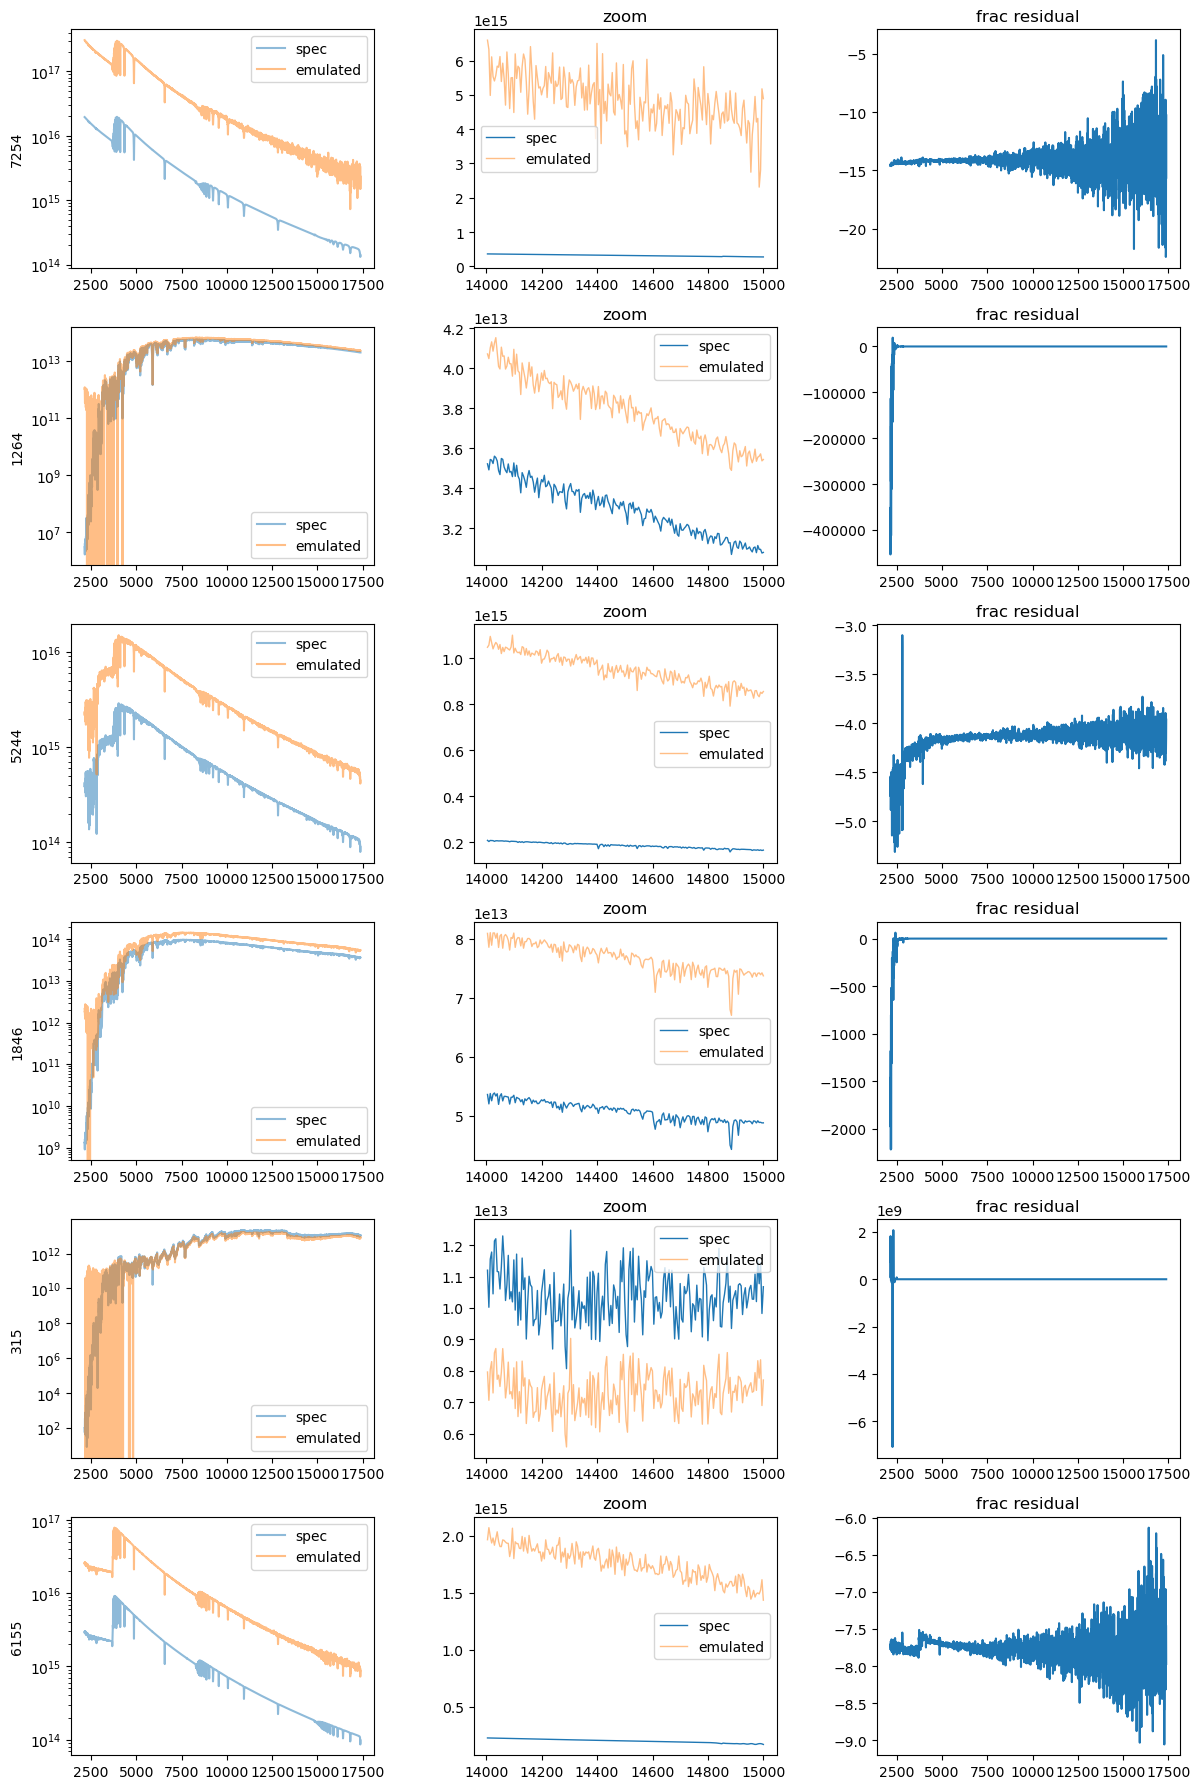

In [29]:
np.random.seed(44)
randidxs = np.random.permutation(fluxes.shape[0])[:6]

specs = fluxes[randidxs]
infs = infeatures[randidxs].to(device)

evaltimes = []

wl = data_wls.to(u.Angstrom).value

fig, axs = plt.subplots(len(randidxs), 3, figsize=(12, len(randidxs)*3))
for spec, inf, axrow, idx in zip(specs, infs, axs, randidxs):
    ax1, ax2, ax3 = axrow
    
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    _ = combined.forward(inf.reshape(1, 3))
    end.record()
    pred = combined.forward_descale(inf.reshape(1, 3)).detach().cpu()[0]
    ax1.semilogy(wl, spec, label='spec', alpha=.5)
    ax1.semilogy(wl, pred, label='emulated', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_ylabel(f'{idx}')

    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], spec[msk].cpu(), lw=1, label='spec')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='emulated', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'zoom')

    ax3.plot(wl, (spec-pred)/spec)
    ax3.set_title('frac residual')

    torch.cuda.synchronize()
    evaltimes.append(start.elapsed_time(end))
    
fig.tight_layout()

evaltimes #in ms for just the nn eval part

Uhm... somethings clearly broken with the scaling.

# Save the trained models

In [30]:
for modnm in ['aec', 'mlp', 'combined']:
    pth = Path(f'{modnm}.pth')
    if pth.exists():
        print(f'not saving {modnm} becasue it already exists')
    else:
        print(f'saving {modnm}')
        torch.save(globals()[modnm], str(pth))

saving aec
saving mlp
saving combined
